<a href="https://colab.research.google.com/github/HelgaIngridHochbauer/Geometry/blob/main/CG_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gradio matplotlib pillow scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


exhaustive search:

Enter the number of points to generate (minimum 3): 450

Results:
Number of points: 450
Rectangle center: (0.02, 0.00)
Rectangle area: 397.59
Rectangle extents: [9.98, 9.96]
Exhaustive search time: 0.0013 seconds


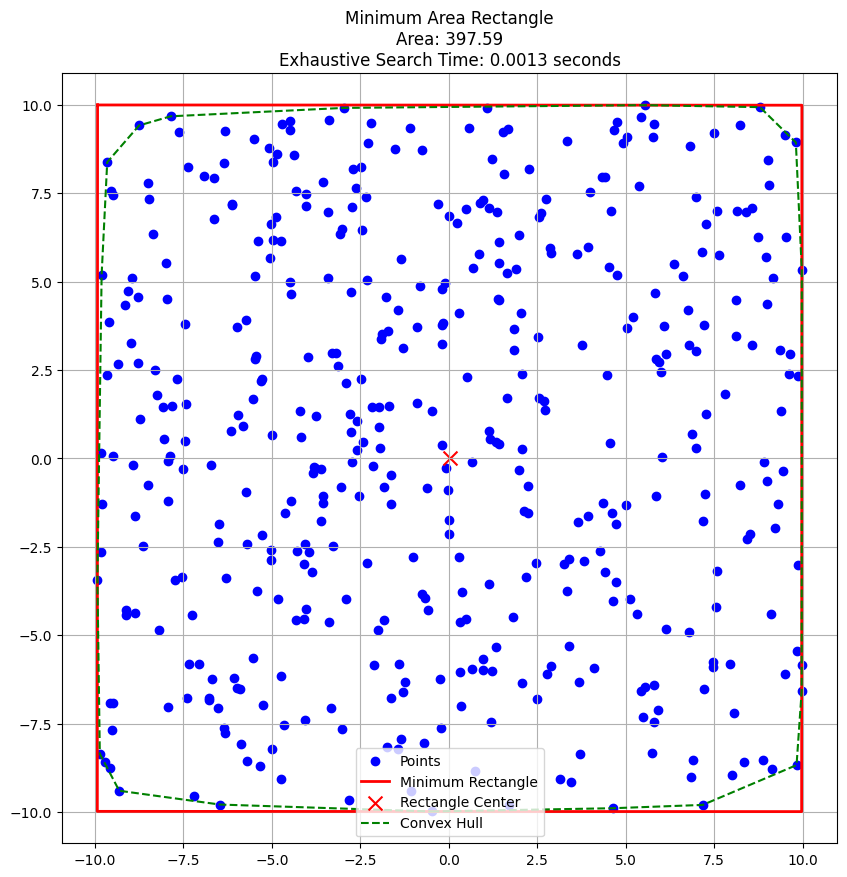

In [ ]:

import numpy as np
from typing import List, Tuple, NamedTuple
import matplotlib.pyplot as plt
import time

class Rectangle(NamedTuple):
    """Rectangle representation with center, axes, extents, and area."""
    center: np.ndarray
    axis: List[np.ndarray]
    extent: List[float]
    area: float

def generate_random_points(n: int, min_val: float = -10, max_val: float = 10) -> List[Tuple[float, float]]:
    """Generate n random 2D points within the specified range."""
    points = []
    for _ in range(n):
        x = np.random.uniform(min_val, max_val)
        y = np.random.uniform(min_val, max_val)
        points.append((x, y))
    return points

def compute_convex_hull(points: List[np.ndarray]) -> List[np.ndarray]:
    """Compute the convex hull of a set of points using Graham scan."""
    if len(points) < 3:
        return points

    pivot = min(points, key=lambda p: (p[1], p[0]))

    def sort_key(p):
        if np.array_equal(p, pivot):
            return (-float('inf'), 0)
        angle = np.arctan2(p[1] - pivot[1], p[0] - pivot[0])
        dist = np.sum((p - pivot) ** 2)
        return (angle, dist)

    sorted_points = sorted(points, key=sort_key)

    hull = []
    for point in sorted_points:
        while len(hull) >= 2:
            p1, p2 = hull[-2], hull[-1]
            cross = np.cross(p2 - p1, point - p1)
            if cross <= 0:
                hull.pop()
            else:
                break
        hull.append(point)

    return hull

def perpendicular(v: np.ndarray) -> np.ndarray:
    """Returns a vector perpendicular to the input vector."""
    return np.array([-v[1], v[0]])

def exhaustive_search_min_rect(polygon: List[np.ndarray]) -> Tuple[Rectangle, float]:
    """
    Perform the exhaustive search part of minimum area rectangle computation.
    Returns the rectangle and the time taken for the search.
    """
    min_rect = Rectangle(
        center=np.zeros(2),
        axis=[np.zeros(2), np.zeros(2)],
        extent=[0.0, 0.0],
        area=float('inf')
    )

    start_time = time.time()

    n = len(polygon)
    for i0 in range(n):
        i1 = (i0 + 1) % n
        origin = polygon[i0]
        U0 = polygon[i1] - origin
        length = np.linalg.norm(U0)

        if length < 1e-10:
            continue

        U0 = U0 / length
        U1 = perpendicular(U0)

        min0, max0 = float('inf'), float('-inf')
        min1, max1 = float('inf'), float('-inf')

        for point in polygon:
            D = point - origin
            dot0 = np.dot(U0, D)
            dot1 = np.dot(U1, D)

            min0 = min(min0, dot0)
            max0 = max(max0, dot0)
            min1 = min(min1, dot1)
            max1 = max(max1, dot1)

        area = (max0 - min0) * (max1 - min1)

        if area < min_rect.area:
            center = origin + ((min0 + max0) / 2) * U0 + ((min1 + max1) / 2) * U1
            min_rect = Rectangle(
                center=center,
                axis=[U0, U1],
                extent=[(max0 - min0) / 2, (max1 - min1) / 2],
                area=area
            )

    search_time = time.time() - start_time
    return min_rect, search_time

def min_area_rectangle_of_points(points: List[Tuple[float, float]]) -> Tuple[Rectangle, float]:
    """Compute the minimum-area rectangle containing the points."""
    if len(points) < 3:
        raise ValueError("At least 3 points are required")

    np_points = [np.array(p) for p in points]
    polygon = compute_convex_hull(np_points)
    return exhaustive_search_min_rect(polygon)

def plot_result(points: List[Tuple[float, float]], rect: Rectangle, search_time: float):
    """Plot the points and minimum area rectangle."""
    points = np.array(points)
    plt.figure(figsize=(10, 10))

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points')

    # Plot rectangle
    center = rect.center
    axis0, axis1 = rect.axis
    extent0, extent1 = rect.extent

    corners = [
        center + extent0 * axis0 + extent1 * axis1,
        center + extent0 * axis0 - extent1 * axis1,
        center - extent0 * axis0 - extent1 * axis1,
        center - extent0 * axis0 + extent1 * axis1,
        center + extent0 * axis0 + extent1 * axis1
    ]

    corners = np.array(corners)
    plt.plot(corners[:, 0], corners[:, 1], 'r-', linewidth=2, label='Minimum Rectangle')
    plt.scatter([center[0]], [center[1]], c='red', marker='x', s=100, label='Rectangle Center')

    # Plot convex hull
    hull_points = compute_convex_hull([np.array(p) for p in points])
    hull_points.append(hull_points[0])  # Close the hull
    hull_points = np.array(hull_points)
    plt.plot(hull_points[:, 0], hull_points[:, 1], 'g--', label='Convex Hull')

    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'Minimum Area Rectangle\nArea: {rect.area:.2f}\nExhaustive Search Time: {search_time:.4f} seconds')
    plt.show()

def main():
    # Get number of points from user
    while True:
        try:
            n_points = int(input("Enter the number of points to generate (minimum 3): "))
            if n_points >= 3:
                break
            print("Please enter a number greater than or equal to 3.")
        except ValueError:
            print("Please enter a valid integer.")

    try:
        # Generate random points
        points = generate_random_points(n_points)

        # Calculate minimum area rectangle and get search time
        rect, search_time = min_area_rectangle_of_points(points)

        # Print results
        print("\nResults:")
        print(f"Number of points: {n_points}")
        print(f"Rectangle center: ({rect.center[0]:.2f}, {rect.center[1]:.2f})")
        print(f"Rectangle area: {rect.area:.2f}")
        print(f"Rectangle extents: [{rect.extent[0]:.2f}, {rect.extent[1]:.2f}]")
        print(f"Exhaustive search time: {search_time:.4f} seconds")

        # Plot the results
        plot_result(points, rect, search_time)

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

The implementation for imprecise points. (Disks, squares)

Choose an option:
1. Squares only
2. Discs only
3. Both squares and discs
Enter your choice (1/2/3): 3
Enter the number of squares: 50
Enter the number of discs: 50


Bounding box: (-13.921325931776146, 14.349240990746026, -13.719350906210025, 14.063072513026837)
Time taken to compute bounding box: 0.000156 seconds


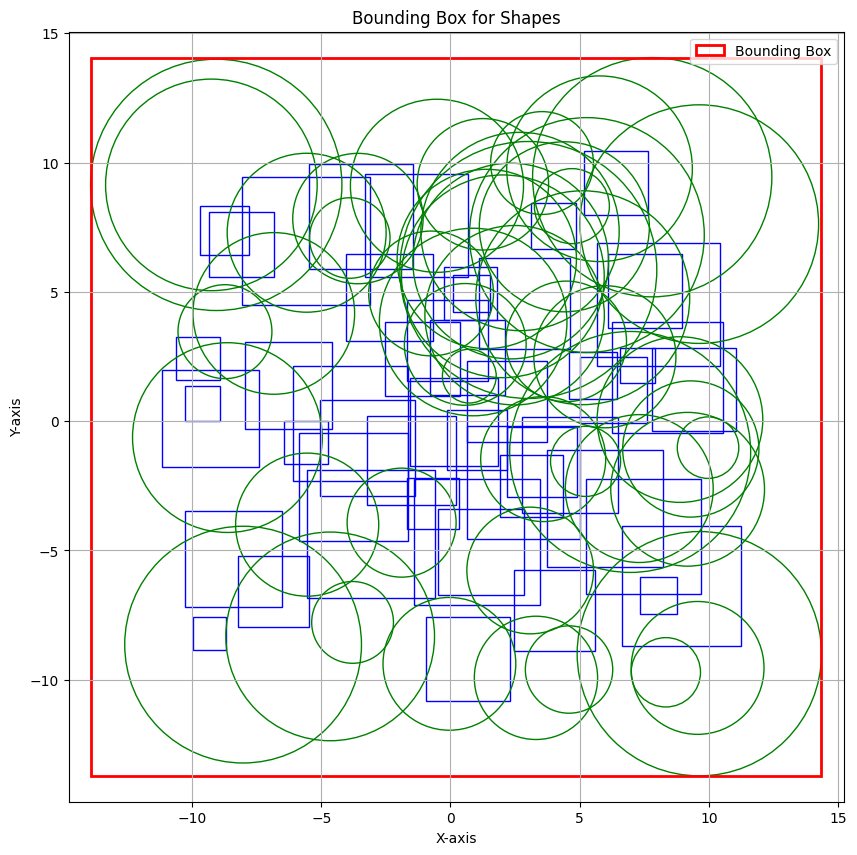

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import time


def generate_random_squares(num_squares, max_center=10, max_side=5):
    return [
        (random.uniform(-max_center, max_center),  # x_center
         random.uniform(-max_center, max_center),  # y_center
         random.uniform(1, max_side))  # side_length
        for _ in range(num_squares)
    ]


def generate_random_discs(num_discs, max_center=10, max_radius=5):
    return [
        (random.uniform(-max_center, max_center),  # x_center
         random.uniform(-max_center, max_center),  # y_center
         random.uniform(1, max_radius))  # radius
        for _ in range(num_discs)
    ]


def bounding_box_for_shapes(squares=None, discs=None):
    x_min_global = float('inf')
    x_max_global = float('-inf')
    y_min_global = float('inf')
    y_max_global = float('-inf')

    if squares:
        for x_center, y_center, side_length in squares:
            half_side = side_length / 2
            x_min = x_center - half_side
            x_max = x_center + half_side
            y_min = y_center - half_side
            y_max = y_center + half_side

            x_min_global = min(x_min_global, x_min)
            x_max_global = max(x_max_global, x_max)
            y_min_global = min(y_min_global, y_min)
            y_max_global = max(y_max_global, y_max)

    if discs:
        for x_center, y_center, radius in discs:
            x_min = x_center - radius
            x_max = x_center + radius
            y_min = y_center - radius
            y_max = y_center + radius

            x_min_global = min(x_min_global, x_min)
            x_max_global = max(x_max_global, x_max)
            y_min_global = min(y_min_global, y_min)
            y_max_global = max(y_max_global, y_max)

    return x_min_global, x_max_global, y_min_global, y_max_global


def plot_bounding_box(squares, discs, bounding_box):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot squares
    if squares:
        for x_center, y_center, side_length in squares:
            half_side = side_length / 2
            rect = patches.Rectangle(
                (x_center - half_side, y_center - half_side),
                side_length, side_length,
                linewidth=1, edgecolor='blue', facecolor='none'
            )
            ax.add_patch(rect)

    # Plot discs
    if discs:
        for x_center, y_center, radius in discs:
            circle = patches.Circle(
                (x_center, y_center),
                radius,
                linewidth=1, edgecolor='green', facecolor='none'
            )
            ax.add_patch(circle)

    # Plot bounding box
    x_min, x_max, y_min, y_max = bounding_box
    bbox_rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min, y_max - y_min,
        linewidth=2, edgecolor='red', facecolor='none', label='Bounding Box'
    )
    ax.add_patch(bbox_rect)

    # Adjust plot limits
    margin = 1  # Add some margin for better visualization
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)

    # Finalize plot
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.set_title('Bounding Box for Shapes')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.grid(True)
    plt.show()


# Main Functionality
print("Choose an option:")
print("1. Squares only")
print("2. Discs only")
print("3. Both squares and discs")
choice = int(input("Enter your choice (1/2/3): "))

squares, discs = [], []

if choice == 1:
    num_squares = int(input("Enter the number of squares: "))
    squares = generate_random_squares(num_squares)
elif choice == 2:
    num_discs = int(input("Enter the number of discs: "))
    discs = generate_random_discs(num_discs)
elif choice == 3:
    num_squares = int(input("Enter the number of squares: "))
    num_discs = int(input("Enter the number of discs: "))
    squares = generate_random_squares(num_squares)
    discs = generate_random_discs(num_discs)
else:
    print("Invalid choice.")
    exit()

# Measure the time taken for bounding box computation
start_time = time.time()
bounding_box = bounding_box_for_shapes(squares, discs)
end_time = time.time()

print("Bounding box:", bounding_box)
print(f"Time taken to compute bounding box: {end_time - start_time:.6f} seconds")

# Visualize the bounding box
plot_bounding_box(squares, discs, bounding_box)


rotating calipers:

Animation saved as 'rotating_calipers.gif'!


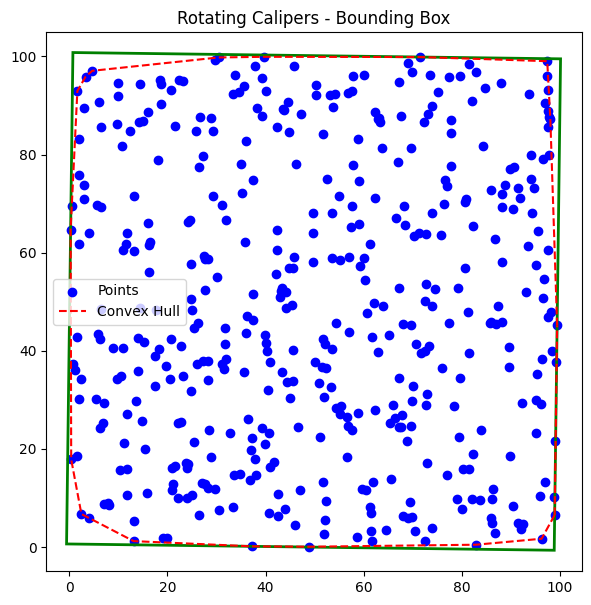

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon


def rotate_points(points, angle):
    """Rotate points by a given angle (in radians)."""
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return np.dot(points, rotation_matrix.T)


def calculate_min_bounding_box_with_animation(points):
    hull = ConvexHull(points)  # Compute convex hull
    hull_points = points[hull.vertices]
    num_hull_points = len(hull_points)
    min_area = float('inf')
    min_box = None
    frames = []

    for i in range(num_hull_points):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % num_hull_points]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])  # Calculate edge angle

        # Rotate points to align edge horizontally
        rotated_points = rotate_points(hull_points, -edge_angle)

        # Compute bounding box in rotated frame
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        width, height = max_x - min_x, max_y - min_y
        area = width * height

        # Update minimum bounding box
        if area < min_area:
            min_area = area
            min_box = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y],
            ])
            # Rotate box back to original space
            min_box = rotate_points(min_box, edge_angle)

        # Save frame for animation
        current_box = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y],
        ])
        current_box = rotate_points(current_box, edge_angle)  # Rotate box back to original space
        frames.append((hull_points.copy(), current_box))

    return min_box, min_area, frames


def plot_rotating_calipers_animation(points, frames):
    """
    Creates an animation showing the Rotating Calipers method.

    Args:
        points (ndarray): Original set of points.
        frames (list): List of frames containing hull points and bounding box at each step.
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    def update(frame):
        ax.clear()
        hull_points, bounding_box = frame

        # Scatter points
        ax.scatter(points[:, 0], points[:, 1], color="blue", label="Points")
        # Plot convex hull
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'r--', label="Convex Hull")
        ax.plot([hull_points[-1, 0], hull_points[0, 0]],
                [hull_points[-1, 1], hull_points[0, 1]], 'r--')  # Close hull shape

        # Display bounding box
        bounding_polygon = Polygon(bounding_box, closed=True, edgecolor="green", facecolor="none", linewidth=2)
        ax.add_patch(bounding_polygon)

        # Set plot limits and properties
        ax.set_xlim(points[:, 0].min() - 5, points[:, 0].max() + 5)
        ax.set_ylim(points[:, 1].min() - 5, points[:, 1].max() + 5)
        ax.set_title("Rotating Calipers - Bounding Box")
        ax.set_aspect('equal', adjustable='box')
        ax.legend()

    anim = FuncAnimation(fig, update, frames=frames, interval=800, repeat=False)

    # Save as a GIF file
    writer = PillowWriter(fps=2)
    anim.save("rotating_calipers.gif", writer=writer)
    print("Animation saved as 'rotating_calipers.gif'!")

    plt.show()


# Generate random points
np.random.seed(0)
points = np.random.rand(450, 2) * 100

# Run the calculation with animation
min_box, min_area, animation_frames = calculate_min_bounding_box_with_animation(points)

# Plot the animation
plot_rotating_calipers_animation(points, animation_frames)

Enter the number of points: 20
Enter the maximum number of outliers allowed (t): 5
Generated points: [(3.3488911492103823, 8.350646689631795), (5.8884401882608275, 0.47758516663616857), (6.862375854111983, 4.083259538987671), (5.2793270857504515, 1.4391607696444475), (2.1990122501493623, 0.8079701004845674), (8.486259815961187, 9.59033805230835), (2.706978129990784, 2.5508718618305015), (9.785620372768044, 5.869753264072281), (4.138107743126069, 8.043292364144298), (4.093861512886648, 2.979818112100183), (4.539934197790454, 6.435576344795727), (4.836331618612951, 1.3990166433182816), (8.65086085944066, 3.6557984348302086), (9.867671436803246, 2.608684048514922), (4.438814151258033, 1.671848040136964), (5.296279669964833, 3.209968961625961), (2.8936814439962912, 7.841848545279992), (1.8837391282244098, 8.437153730897796), (3.1955035459195957, 4.793421867911639), (7.574511270688404, 1.489680459245064)]
GIF saved as algorithm_visualization.gif


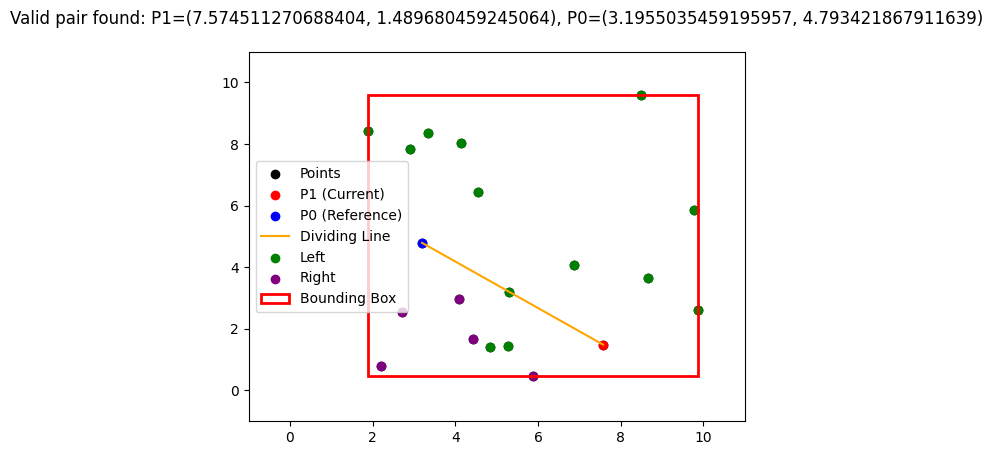

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
from typing import List, Tuple


def generate_random_points(n: int, x_range: Tuple[int, int], y_range: Tuple[int, int]) -> List[Tuple[float, float]]:
    return [(random.uniform(*x_range), random.uniform(*y_range)) for _ in range(n)]


def calculate_bounding_box(points: List[Tuple[float, float]]) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    x_min = min(p[0] for p in points)
    x_max = max(p[0] for p in points)
    y_min = min(p[1] for p in points)
    y_max = max(p[1] for p in points)
    return (x_min, y_min), (x_max, y_max)


def visualize_algorithm(points: List[Tuple[float, float]], t: int, save_gif: bool = True):
    fig, ax = plt.subplots()
    frames = []  # Store frames for animation

    def plot_step(P1, P0, left_points, right_points, description, bbox=None):
        ax.clear()
        ax.set_xlim(-1, 11)
        ax.set_ylim(-1, 11)

        # Add description text above the plot
        ax.set_title(description, fontsize=12, pad=20)

        # Plot all points
        x, y = zip(*points)
        ax.scatter(x, y, c="black", label="Points")

        # Highlight P1 and P0
        ax.scatter(*P1, c="red", label="P1 (Current)")
        ax.scatter(*P0, c="blue", label="P0 (Reference)")

        # Draw the dividing line
        ax.plot([P1[0], P0[0]], [P1[1], P0[1]], "orange", label="Dividing Line")

        # Plot left and right points
        if left_points:
            lx, ly = zip(*left_points)
            ax.scatter(lx, ly, c="green", label="Left")
        if right_points:
            rx, ry = zip(*right_points)
            ax.scatter(rx, ry, c="purple", label="Right")

        # Plot bounding box if provided
        if bbox:
            rect = plt.Rectangle(
                bbox[0],
                bbox[1][0] - bbox[0][0],
                bbox[1][1] - bbox[0][1],
                edgecolor="red",
                facecolor="none",
                linewidth=2,
                label="Bounding Box"
            )
            ax.add_patch(rect)

        ax.legend()

    for i, P1 in enumerate(points):
        for j, P0 in enumerate(points):
            if i == j:
                continue

            left_points = []
            right_points = []
            for k, P in enumerate(points):
                if k == i or k == j:
                    continue
                cross_product = (P[0] - P1[0]) * (P0[1] - P1[1]) - (P[1] - P1[1]) * (P0[0] - P1[0])
                if cross_product > 0:
                    left_points.append(P)
                elif cross_product < 0:
                    right_points.append(P)

            left_points.sort(key=lambda P: np.arctan2(P[1] - P1[1], P[0] - P1[0]))
            right_points.sort(key=lambda P: np.arctan2(P[1] - P1[1], P[0] - P1[0]))

            nL = len(left_points)
            nR = len(right_points)
            step_count = 0
            bbox = calculate_bounding_box(points) if step_count == 0 else None

            while len(right_points) > 0:
                description = f"Looking for valid pair: P1={P1}, P0={P0}\nLeft count: {nL}, Right count: {nR}"
                frames.append((P1, P0, left_points.copy(), right_points.copy(), description, bbox))
                step_count += 1

                if nL <= t or nR <= t:
                    description = f"Valid pair found: P1={P1}, P0={P0}"
                    frames.append((P1, P0, left_points.copy(), right_points.copy(), description, bbox))
                    break

                if len(left_points) > 0 and (len(right_points) == 0 or
                                             np.arctan2(right_points[0][1] - P1[1], right_points[0][0] - P1[0]) >
                                             np.arctan2(left_points[0][1] - P1[1], left_points[0][0] - P1[0])):
                    description = "Moving point from left to right"
                    P2 = left_points.pop(0)
                    right_points.append(P2)
                    nL -= 1
                    nR += 1
                else:
                    description = "Moving point from right to left"
                    P2 = right_points.pop(0)
                    left_points.append(P2)
                    nL += 1
                    nR -= 1

    def update(frame):
        P1, P0, left_points, right_points, description, bbox = frame
        plot_step(P1, P0, left_points, right_points, description, bbox)

    animation = FuncAnimation(fig, update, frames=frames, interval=200, repeat=False)

    if save_gif:
        animation.save("algorithm_visualization.gif", writer="pillow", fps=5)
        print("GIF saved as algorithm_visualization.gif")

    plt.show()


# Main Function
if __name__ == "__main__":
    num_points = int(input("Enter the number of points: "))
    t = int(input("Enter the maximum number of outliers allowed (t): "))

    points = generate_random_points(num_points, x_range=(0, 10), y_range=(0, 10))
    print(f"Generated points: {points}")
    visualize_algorithm(points, t)


my implementation of the hybrid approach:

Enter the number of points for the polygon: 4
Enter x-coordinate for point 1: 1
Enter y-coordinate for point 1: 1
Enter x-coordinate for point 2: -4
Enter y-coordinate for point 2: 5
Enter x-coordinate for point 3: 0
Enter y-coordinate for point 3: -8
Enter x-coordinate for point 4: 9
Enter y-coordinate for point 4: 9
Using Exhaustive Search algorithm.


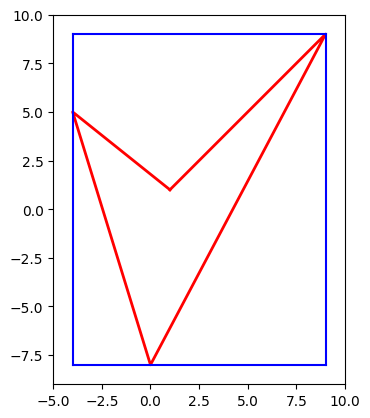

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Function to manually input polygon points
def input_polygon_points():
    n_points = int(input("Enter the number of points for the polygon: "))
    points = []
    for i in range(n_points):
        x = float(input(f"Enter x-coordinate for point {i + 1}: "))
        y = float(input(f"Enter y-coordinate for point {i + 1}: "))
        points.append([x, y])
    return np.array(points)

# Function to find the convex hull
def convex_hull(points):
    hull = ConvexHull(points)
    return points[hull.vertices]

# Exhaustive Search Method (simple approach)
def bounding_box_exhaustive(points):
    min_x = min(points[:, 0])
    max_x = max(points[:, 0])
    min_y = min(points[:, 1])
    max_y = max(points[:, 1])
    return min_x, min_y, max_x, max_y

# Rotate points by a given angle (in radians)
def rotate_points(points, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return np.dot(points, rotation_matrix.T)

# Full Rotating Calipers Implementation
def rotating_calipers(points):
    hull = ConvexHull(points)  # Compute convex hull
    hull_points = points[hull.vertices]
    num_hull_points = len(hull_points)
    min_area = float('inf')
    min_box = None

    # Loop through each edge of the convex hull
    for i in range(num_hull_points):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % num_hull_points]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])  # Calculate edge angle

        # Rotate points so that edge aligns horizontally
        rotated_points = rotate_points(hull_points, -edge_angle)
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        width, height = max_x - min_x, max_y - min_y
        area = width * height

        if area < min_area:  # Update minimum bounding box
            min_area = area
            min_box = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y],
            ])
            # Rotate bounding box back to original space
            min_box = rotate_points(min_box, edge_angle)

    return min_box, min_area

# Hybrid Approach
def hybrid_bounding_box(points):
    # Compute convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Proper convexity check
    def is_convex(polygon_points):
        n = len(polygon_points)
        for i in range(n):
            p1, p2, p3 = polygon_points[i], polygon_points[(i + 1) % n], polygon_points[(i + 2) % n]
            cross_product = np.cross(p2 - p1, p3 - p2)
            if cross_product < 0:  # If any cross product is negative, not convex
                return False
        return True

    if is_convex(points):
        # Convex polygon - Use Rotating Calipers
        print("Using Rotating Calipers algorithm.")
        return rotating_calipers(hull_points)
    else:
        # Non-convex polygon - Use Exhaustive Search on Convex Hull
        print("Using Exhaustive Search algorithm.")
        min_x, min_y, max_x, max_y = bounding_box_exhaustive(hull_points)
        bounding_box = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y],
        ])
        return bounding_box, (max_x - min_x) * (max_y - min_y)


# Input polygon points
polygon_points = input_polygon_points()

# Get bounding box using hybrid approach
bounding_box, area = hybrid_bounding_box(polygon_points)

# Plotting the polygon and bounding box
fig, ax = plt.subplots()
# Ensure the polygon visually closes by appending the first point at the end
polygon_points_closed = np.vstack([polygon_points, polygon_points[0]])
ax.plot(polygon_points_closed[:, 0], polygon_points_closed[:, 1], color='r', linestyle='-', linewidth=2)


# Handling bounding box output dynamically
if isinstance(bounding_box[0], np.ndarray):
    # Case for rotating calipers bounding box
    # The four points returned by rotating calipers are the corners of the bounding box
    # We need to compute the min and max values from those points
    x_coords = [point[0] for point in bounding_box]
    y_coords = [point[1] for point in bounding_box]

    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
else:
    # Case for exhaustive bounding box
    min_x, min_y, max_x, max_y = bounding_box

# Drawing the bounding box
plt.plot([min_x, max_x], [min_y, min_y], color='b')
plt.plot([min_x, max_x], [max_y, max_y], color='b')
plt.plot([min_x, min_x], [min_y, max_y], color='b')
plt.plot([max_x, max_x], [min_y, max_y], color='b')

# Dynamically adjust the plot limits based on the polygon points
all_x = polygon_points[:, 0]
all_y = polygon_points[:, 1]
padding = 1  # Optional padding to ensure the polygon doesn't touch the edges

plt.xlim(min(all_x) - padding, max(all_x) + padding)
plt.ylim(min(all_y) - padding, max(all_y) + padding)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


the final version of the project with interface:

In [ ]:
import numpy as np
from typing import List, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
import time
from PIL import Image
import gradio as gr
import matplotlib.patches as patches
import random
import io
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon


@dataclass
class Rectangle:
    """Rectangle representation with center, axes, extents, and area."""
    center: np.ndarray
    axis: List[np.ndarray]
    extent: List[float]
    area: float

def generate_random_points(n: int, min_val: float = -10, max_val: float = 10) -> List[Tuple[float, float]]:
    """Generate n random 2D points within the specified range."""
    points = []
    for _ in range(n):
        x = np.random.uniform(min_val, max_val)
        y = np.random.uniform(min_val, max_val)
        points.append((x, y))
    return points

def compute_convex_hull(points: List[np.ndarray]) -> List[np.ndarray]:
    """Compute the convex hull of a set of points using Graham scan."""
    if len(points) < 3:
        return points

    # Find point with lowest y-coordinate (and leftmost if tied)
    pivot = min(points, key=lambda p: (p[1], p[0]))

    # Sort points based on polar angle and distance from pivot
    def sort_key(p):
        if np.array_equal(p, pivot):
            return (-float('inf'), 0)
        angle = np.arctan2(p[1] - pivot[1], p[0] - pivot[0])
        dist = np.sum((p - pivot) ** 2)
        return (angle, dist)

    sorted_points = sorted(points, key=sort_key)

    # Graham scan algorithm
    hull = []
    for point in sorted_points:
        while len(hull) >= 2:
            p1, p2 = hull[-2], hull[-1]
            cross = np.cross(p2 - p1, point - p1)
            if cross <= 0:
                hull.pop()
            else:
                break
        hull.append(point)

    return hull

def perpendicular(v: np.ndarray) -> np.ndarray:
    """Returns a vector perpendicular to the input vector."""
    return np.array([-v[1], v[0]])

def min_area_rectangle_of_points(points: List[Tuple[float, float]]) -> Rectangle:
    """Compute the minimum-area rectangle containing the points."""
    if len(points) < 3:
        raise ValueError("At least 3 points are required")

    np_points = [np.array(p) for p in points]
    polygon = compute_convex_hull(np_points)

    min_rect = Rectangle(
        center=np.zeros(2),
        axis=[np.zeros(2), np.zeros(2)],
        extent=[0.0, 0.0],
        area=float('inf')
    )

    n = len(polygon)
    for i0 in range(n):
        i1 = (i0 + 1) % n
        origin = polygon[i0]
        U0 = polygon[i1] - origin
        length = np.linalg.norm(U0)

        if length < 1e-10:
            continue

        U0 = U0 / length
        U1 = perpendicular(U0)

        min0, max0 = float('inf'), float('-inf')
        min1, max1 = float('inf'), float('-inf')

        for point in polygon:
            D = point - origin
            dot0 = np.dot(U0, D)
            dot1 = np.dot(U1, D)

            min0 = min(min0, dot0)
            max0 = max(max0, dot0)
            min1 = min(min1, dot1)
            max1 = max(max1, dot1)

        area = (max0 - min0) * (max1 - min1)

        if area < min_rect.area:
            center = origin + ((min0 + max0) / 2) * U0 + ((min1 + max1) / 2) * U1
            min_rect = Rectangle(
                center=center,
                axis=[U0, U1],
                extent=[(max0 - min0) / 2, (max1 - min1) / 2],
                area=area
            )

    return min_rect

def plot_result(points: List[Tuple[float, float]], rect: Rectangle, computation_time: float):
    """Plot the points and minimum area rectangle."""
    points = np.array(points)
    plt.figure(figsize=(10, 10))

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points')

    # Plot rectangle
    center = rect.center
    axis0, axis1 = rect.axis
    extent0, extent1 = rect.extent

    corners = [
        center + extent0 * axis0 + extent1 * axis1,
        center + extent0 * axis0 - extent1 * axis1,
        center - extent0 * axis0 - extent1 * axis1,
        center - extent0 * axis0 + extent1 * axis1,
        center + extent0 * axis0 + extent1 * axis1
    ]

    corners = np.array(corners)
    plt.plot(corners[:, 0], corners[:, 1], 'r-', linewidth=2, label='Minimum Rectangle')
    plt.scatter([center[0]], [center[1]], c='red', marker='x', s=100, label='Rectangle Center')

    # Plot convex hull
    hull_points = compute_convex_hull([np.array(p) for p in points])
    hull_points.append(hull_points[0])  # Close the hull
    hull_points = np.array(hull_points)
    plt.plot(hull_points[:, 0], hull_points[:, 1], 'g--', label='Convex Hull')

    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'Minimum Area Rectangle\nArea: {rect.area:.2f}\nComputation Time: {computation_time:.4f} seconds')
    plt.show()

def generate_random_squares(num_squares, max_center=10, max_side=5):
    return [
        (random.uniform(-max_center, max_center),  # x_center
         random.uniform(-max_center, max_center),  # y_center
         random.uniform(1, max_side))  # side_length
        for _ in range(num_squares)
    ]

def generate_random_discs(num_discs, max_center=10, max_radius=5):
    return [
        (random.uniform(-max_center, max_center),  # x_center
         random.uniform(-max_center, max_center),  # y_center
         random.uniform(1, max_radius))  # radius
        for _ in range(num_discs)
    ]

def bounding_box_for_shapes(squares=None, discs=None):
    x_min_global = float('inf')
    x_max_global = float('-inf')
    y_min_global = float('inf')
    y_max_global = float('-inf')

    if squares:
        for x_center, y_center, side_length in squares:
            half_side = side_length / 2
            x_min = x_center - half_side
            x_max = x_center + half_side
            y_min = y_center - half_side
            y_max = y_center + half_side

            x_min_global = min(x_min_global, x_min)
            x_max_global = max(x_max_global, x_max)
            y_min_global = min(y_min_global, y_min)
            y_max_global = max(y_max_global, y_max)

    if discs:
        for x_center, y_center, radius in discs:
            x_min = x_center - radius
            x_max = x_center + radius
            y_min = y_center - radius
            y_max = y_center + radius

            x_min_global = min(x_min_global, x_min)
            x_max_global = max(x_max_global, x_max)
            y_min_global = min(y_min_global, y_min)
            y_max_global = max(y_max_global, y_max)

    return x_min_global, x_max_global, y_min_global, y_max_global

def plot_bounding_box(squares, discs, bounding_box):
    fig, ax = plt.subplots(figsize=(10, 10))

    if squares:
        for x_center, y_center, side_length in squares:
            half_side = side_length / 2
            rect = patches.Rectangle(
                (x_center - half_side, y_center - half_side),
                side_length, side_length,
                linewidth=1, edgecolor='blue', facecolor='none'
            )
            ax.add_patch(rect)

    if discs:
        for x_center, y_center, radius in discs:
            circle = patches.Circle(
                (x_center, y_center),
                radius,
                linewidth=1, edgecolor='green', facecolor='none'
            )
            ax.add_patch(circle)

    x_min, x_max, y_min, y_max = bounding_box
    bbox_rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min, y_max - y_min,
        linewidth=2, edgecolor='red', facecolor='none', label='Bounding Box'
    )
    ax.add_patch(bbox_rect)

    margin = 1
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.set_title('Bounding Box for Shapes')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.grid(True)

def bounding_box_for_imprecise_points(num_squares=0, num_discs=0):
    squares = generate_random_squares(int(num_squares)) if num_squares > 0 else []
    discs = generate_random_discs(int(num_discs)) if num_discs > 0 else []

    start_time = time.time()
    bounding_box = bounding_box_for_shapes(squares, discs)
    end_time = time.time()

    buffer = io.BytesIO()
    plot_bounding_box(squares, discs, bounding_box)
    plt.savefig(buffer, format='png')
    plt.close()
    buffer.seek(0)

    image = Image.open(buffer)
    return f"Bounding box: {bounding_box}\nTime taken: {end_time - start_time:.6f} seconds", image

def calculate_min_bounding_box_with_animation(points):
    def rotate_points(points, angle):
        """Rotate points by a given angle (in radians)."""
        rotation_matrix = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])
        return np.dot(points, rotation_matrix.T)

    hull = ConvexHull(points)  # Compute convex hull
    hull_points = points[hull.vertices]
    num_hull_points = len(hull_points)
    min_area = float('inf')
    min_box = None
    frames = []

    for i in range(num_hull_points):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % num_hull_points]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])  # Calculate edge angle

        rotated_points = rotate_points(hull_points, -edge_angle)  # Rotate points to align edge horizontally
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        width, height = max_x - min_x, max_y - min_y
        area = width * height

        if area < min_area:  # Update minimum bounding box
            min_area = area
            min_box = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y],
            ])
            min_box = rotate_points(min_box, edge_angle)  # Rotate box back to original space

        # Save frame for animation
        current_box = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y],
        ])
        frames.append((hull_points.copy(), rotate_points(current_box, edge_angle)))

    return min_box, min_area, frames


def plot_rotating_calipers_animation(points, frames):
    """
    Creates an animation showing the Rotating Calipers method.

    Args:
        points (ndarray): Original set of points.
        frames (list): List of frames containing hull points and bounding box at each step.
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    def update(frame):
        ax.clear()
        hull_points, bounding_box = frame

        # Scatter points
        ax.scatter(points[:, 0], points[:, 1], color="blue", label="Points")
        # Plot convex hull
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'r--', label="Convex Hull")
        ax.plot([hull_points[-1, 0], hull_points[0, 0]],
                [hull_points[-1, 1], hull_points[0, 1]], 'r--')  # Close hull shape

        # Display bounding box
        bounding_polygon = Polygon(bounding_box, closed=True, edgecolor="green", facecolor="none", linewidth=2)
        ax.add_patch(bounding_polygon)

        # Set plot limits and properties
        ax.set_xlim(points[:, 0].min() - 5, points[:, 0].max() + 5)
        ax.set_ylim(points[:, 1].min() - 5, points[:, 1].max() + 5)
        ax.set_title("Rotating Calipers - Bounding Box")
        ax.set_aspect('equal', adjustable='box')
        ax.legend()

    anim = FuncAnimation(fig, update, frames=frames, interval=800, repeat=False)

    # Save as a GIF file
    writer = PillowWriter(fps=2)
    gif_path = "/tmp/rotating_calipers.gif"  # Save the GIF to a file
    anim.save(gif_path, writer=writer)

    return gif_path


def input_polygon_points():
    n_points = int(input("Enter the number of points for the polygon: "))
    points = []
    for i in range(n_points):
        x = float(input(f"Enter x-coordinate for point {i + 1}: "))
        y = float(input(f"Enter y-coordinate for point {i + 1}: "))
        points.append([x, y])
    return np.array(points)

# Function to find the convex hull
def convex_hull(points):
    hull = ConvexHull(points)
    return points[hull.vertices]

# Exhaustive Search Method (simple approach)
def bounding_box_exhaustive(points):
    min_x = min(points[:, 0])
    max_x = max(points[:, 0])
    min_y = min(points[:, 1])
    max_y = max(points[:, 1])
    return min_x, min_y, max_x, max_y

# Rotate points by a given angle (in radians)
def rotate_points(points, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return np.dot(points, rotation_matrix.T)

# Full Rotating Calipers Implementation
def rotating_calipers(points):
    hull = ConvexHull(points)  # Compute convex hull
    hull_points = points[hull.vertices]
    num_hull_points = len(hull_points)
    min_area = float('inf')
    min_box = None

    # Loop through each edge of the convex hull
    for i in range(num_hull_points):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % num_hull_points]
        edge_vector = p2 - p1
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])  # Calculate edge angle

        # Rotate points so that edge aligns horizontally
        rotated_points = rotate_points(hull_points, -edge_angle)
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        width, height = max_x - min_x, max_y - min_y
        area = width * height

        if area < min_area:  # Update minimum bounding box
            min_area = area
            min_box = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y],
            ])
            # Rotate bounding box back to original space
            min_box = rotate_points(min_box, edge_angle)

    return min_box, min_area

# Hybrid Approach
def hybrid_bounding_box(points):
    # Compute convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Proper convexity check
    def is_convex(polygon_points):
        n = len(polygon_points)
        for i in range(n):
            p1, p2, p3 = polygon_points[i], polygon_points[(i + 1) % n], polygon_points[(i + 2) % n]
            cross_product = np.cross(p2 - p1, p3 - p2)
            if cross_product < 0:  # If any cross product is negative, not convex
                return False
        return True

    if is_convex(points):
        # Convex polygon - Use Rotating Calipers
        print("Using Rotating Calipers algorithm.")
        return rotating_calipers(hull_points)
    else:
        # Non-convex polygon - Use Exhaustive Search on Convex Hull
        print("Using Exhaustive Search algorithm.")
        min_x, min_y, max_x, max_y = bounding_box_exhaustive(hull_points)
        bounding_box = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y],
        ])
        return bounding_box, (max_x - min_x) * (max_y - min_y)

def process_hybrid_bounding_box(num_points, coordinates_str):
    try:
        # Parse coordinates
        points = []
        if coordinates_str.strip():
            for pair in coordinates_str.split(";"):
                x, y = map(float, pair.split(","))
                points.append([x, y])
            points = np.array(points)
        else:
            raise ValueError("Coordinates cannot be empty.")

        # Validate the number of points
        if len(points) != num_points:
            raise ValueError("Number of points doesn't match the provided coordinates.")

        # Get bounding box using hybrid approach
        min_box, min_area = hybrid_bounding_box(points)

        # Create a visualization
        buffer = io.BytesIO()
        plt.figure(figsize=(7, 7))
        fig, ax = plt.subplots()

        # Ensure the polygon visually closes by appending the first point at the end
        polygon_points_closed = np.vstack([points, points[0]])
        ax.plot(polygon_points_closed[:, 0], polygon_points_closed[:, 1], color='r', linestyle='-', linewidth=2)

        # Handling bounding box output dynamically
        if isinstance(min_box[0], np.ndarray):
            # Rotating Calipers case
            x_coords = [point[0] for point in min_box]
            y_coords = [point[1] for point in min_box]
            min_x = min(x_coords)
            max_x = max(x_coords)
            min_y = min(y_coords)
            max_y = max(y_coords)
        else:
            # Exhaustive search case
            min_x, min_y, max_x, max_y = min_box

        # Drawing the bounding box
        plt.plot([min_x, max_x], [min_y, min_y], color='b')
        plt.plot([min_x, max_x], [max_y, max_y], color='b')
        plt.plot([min_x, min_x], [min_y, max_y], color='b')
        plt.plot([max_x, max_x], [min_y, max_y], color='b')

        # Dynamically adjust plot limits
        all_x = points[:, 0]
        all_y = points[:, 1]
        padding = 1  # Optional padding
        plt.xlim(min(all_x) - padding, max(all_x) + padding)
        plt.ylim(min(all_y) - padding, max(all_y) + padding)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polygon and Bounding Box Visualization")
        plt.savefig(buffer, format="png")
        plt.close()
        buffer.seek(0)
        image = Image.open(buffer)

        # Prepare results
        result_text = f"Minimum bounding box area: {min_area:.2f}\nBounding Box Coordinates: {min_box.tolist()}"
        return result_text, image

    except Exception as e:
        return str(e), None


# Gradio integration
def rotating_calipers_algorithm(n_points: int):
    points = np.random.rand(n_points, 2) * 100
    min_box, min_area, animation_frames = calculate_min_bounding_box_with_animation(points)
    gif_path = plot_rotating_calipers_animation(points, animation_frames)

    result_text = f"Minimum bounding box area: {min_area:.2f}\n"

    # Return the result text and the file path to the GIF
    return result_text, gif_path

def exhaustive_search(n_points: int):
    try:
        # Generate points
        points = [np.array(p) for p in generate_random_points(n_points)]

        # Compute the minimum area rectangle
        start_time = time.time()
        rect = min_area_rectangle_of_points(points)
        search_time = time.time() - start_time

        # Prepare result text
        result_text = (
            f"Number of points: {n_points}\n"
            f"Rectangle center: ({rect.center[0]:.2f}, {rect.center[1]:.2f})\n"
            f"Rectangle area: {rect.area:.2f}\n"
            f"Rectangle extents: [{rect.extent[0]:.2f}, {rect.extent[1]:.2f}]\n"
            f"Exhaustive search time: {search_time:.4f} seconds"
        )

        # Plot and save the result
        plot_result(points, rect, search_time)
        plot_path = "result_plot.png"
        plt.savefig(plot_path)
        plt.close()

        return result_text, plot_path
    except Exception as e:
        # Handle errors gracefully
        return f"Error: {str(e)}", None



with gr.Blocks() as interface:
    gr.Markdown("## Bounding Box Algorithms")

    with gr.Tab("Exhaustive search"):
        n_points_input = gr.Number(label="Number of Points", value=10, minimum=3)
        result_text = gr.Text(label="Results")
        result_plot = gr.Image(label="Plot")
        submit_button = gr.Button("Run")
        submit_button.click(
            fn=exhaustive_search,
            inputs=[n_points_input],
            outputs=[result_text, result_plot],
        )

    with gr.Tab("Rotating Calipers"):
        n_points_input_rotating = gr.Number(label="Number of Points", value=20, minimum=3)
        result_text_rotating = gr.Text(label="Results")
        animation_output = gr.Image(label="Rotating Calipers Animation", type="filepath")
        submit_button_rotating = gr.Button("Run")
        submit_button_rotating.click(
            fn=rotating_calipers_algorithm,
            inputs=[n_points_input_rotating],
            outputs=[result_text_rotating, animation_output],
        )

    with gr.Tab("Bounding Box for Imprecise Points"):
      num_squares_input = gr.Number(label="Number of Squares")
      num_discs_input = gr.Number(label="Number of Discs")
      results_text_output = gr.Text(label="Results")
      bounding_box_image_output = gr.Image(label="Bounding Box Visualization")

      def bounding_box_fn(num_squares, num_discs):
          return bounding_box_for_imprecise_points(num_squares, num_discs)

      # Add a new submit button for this tab
      submit_button_bounding_box = gr.Button("Run")
      submit_button_bounding_box.click(
          fn=bounding_box_fn,
          inputs=[num_squares_input, num_discs_input],
          outputs=[results_text_output, bounding_box_image_output],
    )

    with gr.Tab("Hybrid Bounding Box"):
      with gr.Row():
        num_points_input = gr.Number(
            label="Number of Points of the Polygon",
            value=5,
            precision=0,
            interactive=True,
            info="Enter the number of points for the polygon."
        )

        coordinates_input = gr.Textbox(
            label="Coordinates",
            placeholder="Enter coordinates as x1,y1;x2,y2;... (e.g., 0,0;1,2;3,4)",
            interactive=True,
            info="Provide coordinates separated by semicolons."
        )

        submit_button_bounding_box = gr.Button("Run")

        # Define output components
        output_text = gr.Text(label="Results")
        output_image = gr.Image(label="Plot")

        # Link the button click to the processing function
        submit_button_bounding_box.click(
            fn=process_hybrid_bounding_box,  # Reference the function, do not call it here
            inputs=[num_points_input, coordinates_input],  # Inputs for the function
            outputs=[output_text, output_image]  # Outputs from the function
        )

interface.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f399a9cad69729bffa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
